### 1. ベースラインの確認とEDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, classification_report
from sklearn.model_selection import train_test_split

In [2]:
# データの読み込み
df = pd.read_csv('stock_price.csv')
df['日付'] = pd.to_datetime(df['日付'])

# 日中の値動きを計算（終値 - 始値）
df['Day_Return'] = df['終値'] - df['始値']

# 計算用に、値動きが0円（引き分け）の日を除外
df_trade = df[df['Day_Return'] != 0].copy()

# 1. 勝ちトレードの平均利益
avg_win = df_trade[df_trade['Day_Return'] > 0]['Day_Return'].mean()

# 2. 負けトレードの平均損失(絶対値にする)
avg_loss = df_trade[df_trade['Day_Return'] < 0]['Day_Return'].abs().mean()

# 3. 損益分岐点の計算
# 公式: 勝率P * 平均Win - (1 - 勝率P) * 平均Loss = 0
# これをPについて解くと -> P = 平均Loss / (平均Win + 平均Loss)
break_even_win_rate = avg_loss / (avg_win + avg_loss)

# 結果の表示
print(f"--- 損益分岐点の計算 ---")
print(f"平均利益 (Avg Win): {avg_win:.4f} 円")
print(f"平均損失 (Avg Loss): {avg_loss:.4f} 円")
print(f"リスクリワード比: {avg_win / avg_loss:.4f}")
print(f"------------------------")
print(f"損益分岐勝率: {break_even_win_rate:.2%}")

--- 損益分岐点の計算 ---
平均利益 (Avg Win): 1.0283 円
平均損失 (Avg Loss): 1.0373 円
リスクリワード比: 0.9913
------------------------
損益分岐勝率: 50.22%


In [3]:
# 図示のための設定
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('bmh')

# ---------------------------------------------------------
# 1. データの読み込みと前処理
# ---------------------------------------------------------
def load_and_preprocess(filepath):
    """データを読み込み、基本的な型変換とソートを行う"""
    df = pd.read_csv(filepath)
    df['日付'] = pd.to_datetime(df['日付'])
    
    # 数値変換関数
    def convert_volume(vol):
        if isinstance(vol, str):
            if 'M' in vol: return float(vol.replace('M', '')) * 1_000_000
            elif 'K' in vol: return float(vol.replace('K', '')) * 1_000
            elif 'B' in vol: return float(vol.replace('B', '')) * 1_000_000_000
        return float(vol)

    df['出来高'] = df['出来高'].apply(convert_volume)
    df['変化率 %'] = df['変化率 %'].str.replace('%', '').astype(float)
    
    # 日付でソート（時系列データの基本）
    df = df.sort_values('日付').reset_index(drop=True)
    return df

# データのロード
df = load_and_preprocess('stock_price.csv')
df.head(3)

,日付,終値,始値,高値,安値,出来高,変化率 %
0,1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,16.25
1,1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-5.43
2,1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,1.74


--- [EDA] データ分析開始 ---
全期間の平均勝率（何もしない場合）: 42.34%
EDA完了: 図表を作成しました。


,日付,終値,始値,高値,安値,出来高,変化率 %,Next_Open,Next_Close,Next_Day_Return,Target,Weekday
0,1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,16.25,176.5,172.5,-4.0,0,3
1,1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-5.43,166.7,175.5,8.8,1,4
2,1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,1.74,176.5,182.4,5.9,1,0


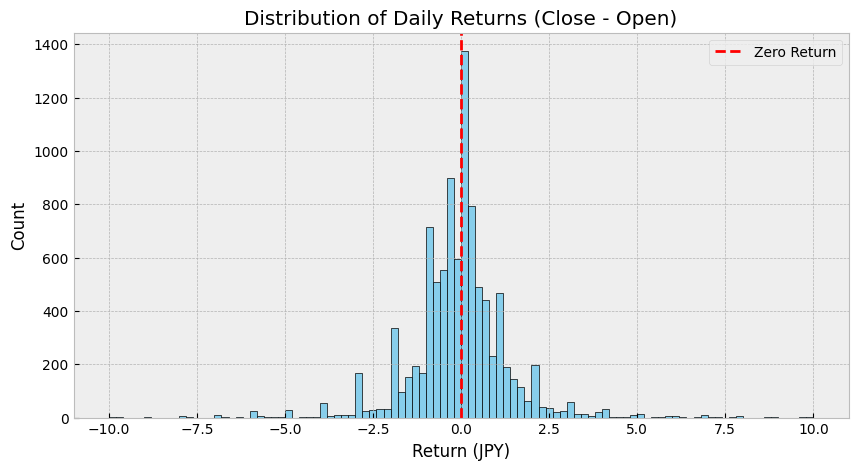

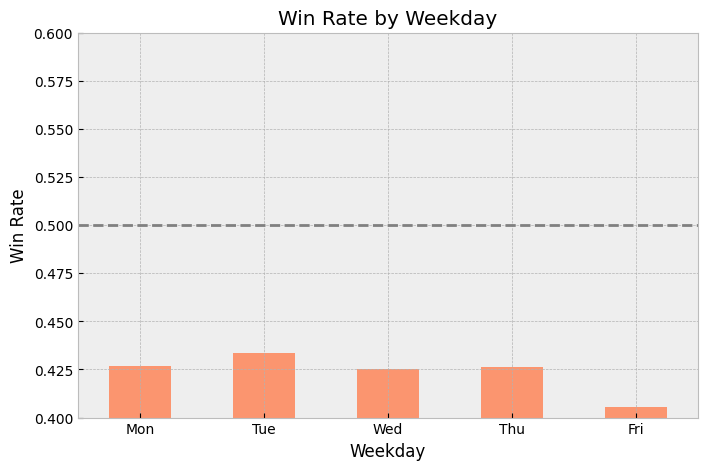

In [4]:
# ---------------------------------------------------------
# 2. EDA: データの理解と洞察
# ---------------------------------------------------------
print("--- [EDA] データ分析開始 ---")

# (1) ターゲット変数の作成（分析用）
# 翌日の始値で買い、翌日の終値で売る -> プラスなら1, それ以外0
# シフト(-1)して未来のデータを「正解」として持ってくる
df['Next_Open'] = df['始値'].shift(-1)
df['Next_Close'] = df['終値'].shift(-1)
df['Next_Day_Return'] = df['Next_Close'] - df['Next_Open']
df['Target'] = (df['Next_Day_Return'] > 0).astype(int)

# (2) ベースライン（何もしない場合の勝率）の確認
baseline_win_rate = df['Target'].mean()
print(f"全期間の平均勝率（何もしない場合）: {baseline_win_rate:.2%}")

# (3) 日中の値動きの分布（ヒストグラム）
plt.figure(figsize=(10, 5))
plt.hist(df['Next_Day_Return'].dropna(), bins=100, range=(-10, 10), color='skyblue', edgecolor='black')
plt.title('Distribution of Daily Returns (Close - Open)')
plt.xlabel('Return (JPY)')
plt.ylabel('Count')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Return')
plt.legend()
plt.savefig('eda_return_dist.png')

# (4) 曜日別の傾向分析
# 鈴木さんが気にすべき「特定の曜日に弱い」などのアノマリーがあるか？
df['Weekday'] = df['日付'].dt.weekday # 0:Mon, ..., 4:Fri
weekday_stats = df.groupby('Weekday')['Target'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']

plt.figure(figsize=(8, 5))
weekday_stats.plot(kind='bar', color='coral', alpha=0.8)
plt.title('Win Rate by Weekday')
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.xticks(range(5), days, rotation=0)
plt.ylabel('Win Rate')
plt.ylim(0.4, 0.6)
plt.savefig('eda_weekday_stats.png')

print("EDA完了: 図表を作成しました。")

df.head(3)

In [5]:
# ---------------------------------------------------------
# 3. 特徴量エンジニアリング
# ---------------------------------------------------------
print("\n--- 特徴量作成開始 ---")

# 鈴木さんの「慎重派」ペルソナに合わせ、テクニカル指標を中心に実装。

df_feat = df.copy()

# A. ローソク足の形状（プライスアクション）
# - Gap_Open: 始値 - 前日終値（夜間の動き、窓開け）
# - Body: 終値 - 始値（日中の強さ）
# - Upper/Lower Shadow: ヒゲの長さ（迷い）
df_feat['Gap_Open'] = df_feat['始値'] - df_feat['終値'].shift(1)
df_feat['Body'] = df_feat['終値'] - df_feat['始値']
df_feat['Upper_Shadow'] = df_feat['高値'] - df_feat[['始値', '終値']].max(axis=1)
df_feat['Lower_Shadow'] = df_feat[['始値', '終値']].min(axis=1) - df_feat['安値']

# B. テクニカル指標（過熱感・トレンド）
# - RSI (14日): 逆張りの定番。買われすぎ(>70)・売られすぎ(<30)の判断。
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_feat['RSI'] = calculate_rsi(df_feat['終値'])

# - 移動平均乖離率 (5日, 25日, 75日): トレンドからの離れ具合
for span in [5, 25, 75]:
    ma = df_feat['終値'].rolling(window=span).mean()
    df_feat[f'MA{span}_Rate'] = (df_feat['終値'] - ma) / ma

# - ボラティリティ (変動率): 最近の値動きが激しいかどうか
df_feat['Volatility'] = (df_feat['高値'] - df_feat['安値']) / df_feat['始値']

# C. ラグ特徴量（過去のパターン）
# 「前日どうだったか」「2日前はどうだったか」を列に追加
for lag in [1, 2, 3]:
    df_feat[f'Body_Lag{lag}'] = df_feat['Body'].shift(lag)
    df_feat[f'Gap_Lag{lag}'] = df_feat['Gap_Open'].shift(lag)
    df_feat[f'Return_Lag{lag}'] = df_feat['変化率 %'].shift(lag)

# 欠損値（計算できない初期データや最後の行）を除去
df_feat = df_feat.dropna()

# 特徴量リストの定義
features = [
    'Gap_Open', 'Body', 'Upper_Shadow', 'Lower_Shadow',
    'RSI', 'MA5_Rate', 'MA25_Rate', 'MA75_Rate', 'Volatility',
    'Weekday',
    'Body_Lag1', 'Gap_Lag1', 'Return_Lag1',
    'Body_Lag2', 'Gap_Lag2', 'Return_Lag2'
]

print(f"作成した特徴量数: {len(features)}個")

df_feat[features].head(3)


--- 特徴量作成開始 ---
作成した特徴量数: 16個


,Gap_Open,Body,Upper_Shadow,Lower_Shadow,RSI,MA5_Rate,MA25_Rate,MA75_Rate,Volatility,Weekday,Body_Lag1,Gap_Lag1,Return_Lag1,Body_Lag2,Gap_Lag2,Return_Lag2
74,3.0,-3.0,0.9,0.0,23.582090,-0.000715,-0.033164,0.036355,0.013810,0,-3.0,4.0,0.36,-2.0,-1.0,-1.07
75,1.0,-2.0,0.0,0.0,26.689189,-0.003579,-0.033347,0.027766,0.007133,1,-3.0,3.0,0.00,-3.0,4.0,0.36
76,-0.9,0.0,1.9,0.0,27.719298,-0.004020,-0.033586,0.019176,0.006847,2,-2.0,1.0,-0.36,-3.0,3.0,0.00


In [6]:
# ---------------------------------------------------------
# 4. モデル構築とトレーニング
# ---------------------------------------------------------
print("\n--- [Model Training] モデル学習開始 ---")

# 時系列分割
# 学習データ: ~2024年 (過去のパターンを覚える)
# テストデータ: 2025年~ (鈴木さんが実際に運用する期間をシミュレーション)
train_df = df_feat[df_feat['日付'] < '2025-01-01']
test_df = df_feat[df_feat['日付'] >= '2025-01-01']

X_train = train_df[features]
y_train = train_df['Target']
X_test = test_df[features]
y_test = test_df['Target']

# モデル選定: RandomForestClassifier
# 理由1: 線形モデルより複雑なパターン（例: RSIが高い かつ 金曜日 なら売られる）を捉えられる。
# 理由2: Feature Importanceにより、どの指標が効いているか説明しやすい。
# 理由3: 比較的パラメータ調整が容易で、デフォルトでもそれなりの性能が出る。
model = RandomForestClassifier(
    n_estimators=400,     # 木の数
    max_depth=10,          # 木の深さ（過学習を防ぐため浅めに設定）
    min_samples_leaf=20,  # 葉の最小データ数（ノイズへの過敏反応を防ぐ）
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("学習完了。")

model


--- [Model Training] モデル学習開始 ---
学習完了。


,n_estimators,400
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



--- [Evaluation] 評価と分析 ---
テスト期間: 2025-01-06 〜 2025-12-29
テストデータ数: 242日

検証結果（閾値別パフォーマンス）:
  Threshold  Trades Precision  Total_Return_JPY
0      0.50       3    66.67%               1.4
1      0.51       2    50.00%               0.1
2      0.52       1   100.00%               1.2
3      0.53       0     0.00%               0.0
4      0.54       0     0.00%               0.0
5      0.55       0     0.00%               0.0

分析完了。Feature Importanceの上位特徴量:
MA25_Rate     0.090084
MA5_Rate      0.085574
MA75_Rate     0.083780
Volatility    0.081984
RSI           0.079288
dtype: float64


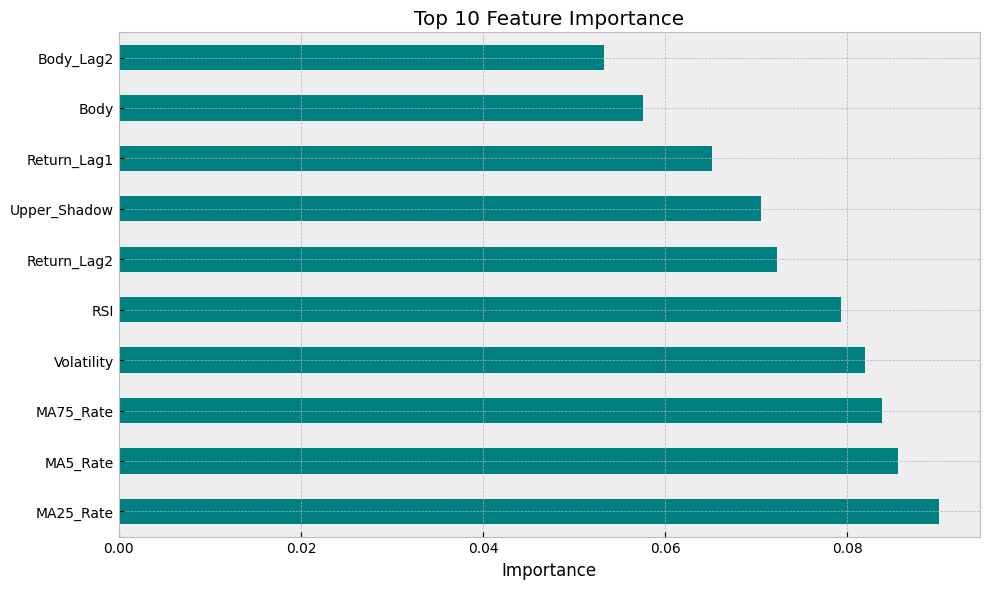

In [7]:
# ---------------------------------------------------------
# 5. モデル評価と結果分析
# ---------------------------------------------------------
print("\n--- [Evaluation] 評価と分析 ---")

# 確率（確信度）の予測
probs = model.predict_proba(X_test)[:, 1] # 1(上昇)になる確率

# 閾値を変えて検証（鈴木さんの「確信度が高いときだけ買う」戦略）
thresholds = [0.50, 0.51, 0.52, 0.53, 0.54, 0.55]
results = []

print(f"テスト期間: {test_df['日付'].min().date()} 〜 {test_df['日付'].max().date()}")
print(f"テストデータ数: {len(test_df)}日")

for th in thresholds:
    # 閾値以上のものだけ抽出
    buy_mask = probs >= th
    
    if buy_mask.sum() > 0:
        # Precision: 買った日のうち、本当に上がった割合
        precision = y_test[buy_mask].mean()
        count = buy_mask.sum()
        # 損益シミュレーション（1単元あたりの獲得値幅）
        total_return = test_df.loc[buy_mask, 'Next_Day_Return'].sum()
    else:
        precision = 0
        count = 0
        total_return = 0
    
    results.append({
        'Threshold': f"{th:.2f}",
        'Trades': count,
        'Precision': f"{precision:.2%}",
        'Total_Return_JPY': total_return
    })

results_df = pd.DataFrame(results)
print("\n検証結果（閾値別パフォーマンス）:")
print(results_df)

# 特徴量重要度の可視化（なぜその予測になったか？）
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.head(10).plot(kind='barh', color='teal')
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')

print("\n分析完了。Feature Importanceの上位特徴量:")
print(importances.head(5))

In [8]:
df.head(3)

,日付,終値,始値,高値,安値,出来高,変化率 %,Next_Open,Next_Close,Next_Day_Return,Target,Weekday
0,1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,16.25,176.5,172.5,-4.0,0,3
1,1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-5.43,166.7,175.5,8.8,1,4
2,1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,1.74,176.5,182.4,5.9,1,0


### 2. モデルの改善（特徴量の見直し）

C:\Users\LoNebula\AppData\Local\Temp\ipykernel_23168\3272675910.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekdays_label, y=weekday_stats.values, palette='viridis')


,日付,終値,始値,高値,安値,出来高,変化率 %,Next_Open,Next_Close,Next_Day_Return,Target,Weekday,Day_Return,Gap
0,1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,16.25,176.5,172.5,-4.0,0,3,0.0,NaN
1,1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-5.43,166.7,175.5,8.8,0,4,-4.0,-5.9
2,1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,1.74,176.5,182.4,5.9,1,0,8.8,-5.8


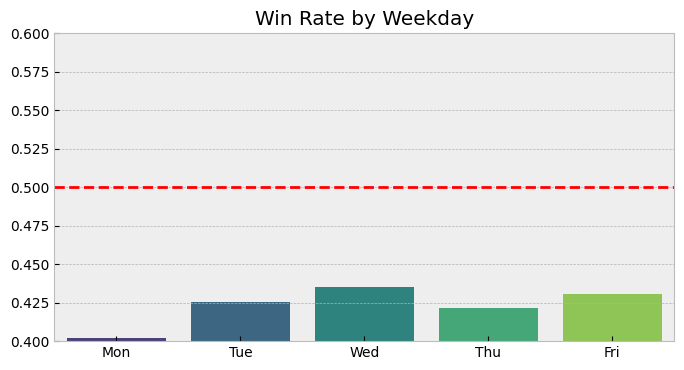

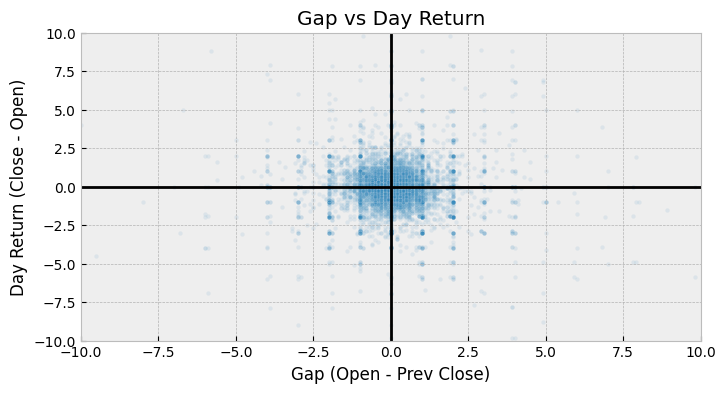

In [9]:
# ---------------------------------------------
# EDA: データの探索
# ---------------------------------------------

# 日中リターン（始値 -> 終値）当日
df['Day_Return'] = df['終値'] - df['始値']
df['Target'] = (df['Day_Return'] > 0).astype(int)

# 1. 曜日ごとの傾向
df['Weekday'] = df['日付'].dt.weekday
weekday_stats = df.groupby('Weekday')['Target'].mean()
weekdays_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']

plt.figure(figsize=(8, 4))
sns.barplot(x=weekdays_label, y=weekday_stats.values, palette='viridis')
plt.axhline(0.5, color='red', linestyle='--', label='50% Line')
plt.title('Win Rate by Weekday')
plt.ylim(0.4, 0.6)
plt.savefig('eda_weekday_fixed.png')

# 2. ギャップ（朝の勢い）と日中リターンの関係
# 前日終値より高く始まったら、利確売りで下がりやすいのか？（逆張り）
df['Gap'] = df['始値'] - df['終値'].shift(1)

plt.figure(figsize=(8, 4))
sns.scatterplot(x=df['Gap'], y=df['Day_Return'], alpha=0.1, s=10)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.title('Gap vs Day Return')
plt.xlabel('Gap (Open - Prev Close)')
plt.ylabel('Day Return (Close - Open)')
plt.xlim(-10, 10) # 外れ値を除外して中心部を見る
plt.ylim(-10, 10)
plt.savefig('eda_gap_scatter.png')

df.head(3)

- 点の多くが (0, 0) の中心付近に密集
- X軸がマイナス（左側）: みんなが怖がって売っている（安く始まった）。
- Y軸がプラス（上側）: 結果として、その日は上がった（陽線）。

In [10]:
# ------------------------------------------------------
# 特徴エンジニアリング
# ------------------------------------------------------

df_feat = df.copy()

# A. テクニカル指標
# RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_feat['RSI'] = calculate_rsi(df_feat['終値'])

# 移動平均乖離率
for span in [5, 25]:
    ma = df_feat['終値'].rolling(window=span).mean()
    df_feat[f'MA{span}_Rate'] = (df_feat['終値'] - ma) / ma

# B. ローソク足の特徴
# 実体の割合（勢い）
df_feat['Body_Rate'] = (df_feat['終値'] - df_feat['始値']) / df_feat['始値']
# ヒゲの長さ（迷い）
df_feat['Upper_Shadow'] = (df_feat['高値'] - df_feat[['始値', '終値']].max(axis=1)) / df_feat['始値']

# C. ラグ特徴量（過去のパターン）
# 「前日大きく下げた(Body_Rate < 0)翌日は？」などをAIに教える
for i in [1, 2, 3]:
    df_feat[f'Body_Lag{i}'] = df_feat['Body_Rate'].shift(i)
    df_feat[f'Gap_Lag{i}'] = (df_feat['Gap'].shift(i)) / df_feat['終値'].shift(i+1)

# D. 独自特徴量：逆張りシグナル
# 「前日の下落幅」×「当日のギャップダウン」＝ 反発のチャンス？
df_feat['Big_Drop_Flag'] = (df_feat['Body_Lag1'] < -0.02).astype(int) # 前日2%以上下落

# E. カレンダー
df_feat['Is_Month_End'] = df_feat['日付'].dt.is_month_end.astype(int)
df_feat['Month'] = df_feat['日付'].dt.month

# 欠損値削除
features = [
    'RSI', 'MA5_Rate', 'MA25_Rate', 'Body_Lag1', 'Gap_Lag1', 
    'Body_Lag2', 'Gap_Lag2', 'Upper_Shadow', 'Big_Drop_Flag', 
    'Weekday', 'Is_Month_End', 'Gap'
]
df_model = df_feat.dropna().reset_index(drop=True)

print("特徴量作成完了。モデル学習へ進みます。")
print(f"特徴量リスト: {features}")

df_feat[features].head(3)

特徴量作成完了。モデル学習へ進みます。
特徴量リスト: ['RSI', 'MA5_Rate', 'MA25_Rate', 'Body_Lag1', 'Gap_Lag1', 'Body_Lag2', 'Gap_Lag2', 'Upper_Shadow', 'Big_Drop_Flag', 'Weekday', 'Is_Month_End', 'Gap']


,RSI,MA5_Rate,MA25_Rate,Body_Lag1,Gap_Lag1,Body_Lag2,Gap_Lag2,Upper_Shadow,Big_Drop_Flag,Weekday,Is_Month_End,Gap
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,3,0,NaN
1,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,0,4,0,-5.9
2,NaN,NaN,NaN,-0.022663,-0.032346,0.0,NaN,0.0,1,0,0,-5.8


In [11]:
# 学習データ: 過去〜2024年末 (AIの教科書)
# テストデータ: 2025年初〜現在 (鈴木さんの本番運用想定)
train_df = df_model[df_model['日付'] < '2025-01-01']
test_df = df_model[df_model['日付'] >= '2025-01-01']

X_train = train_df[features]
y_train = train_df['Target']
X_test = test_df[features]
y_test = test_df['Target']

# 2. モデルの構築と学習
# n_estimators: 木の数
# max_depth: 木の深さ
model = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=10,
    random_state=42
)

print("モデル学習中...")
model.fit(X_train, y_train)
print("学習完了！")

# 3. 予測（確率の算出）
# [0の確率, 1の確率] が返ってくるので、1（上昇）の確率だけ取得
probs = model.predict_proba(X_test)[:, 1]

model

モデル学習中...
学習完了！


,loss,'log_loss'
,learning_rate,0.05
,n_estimators,400
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,10
,min_impurity_decrease,0.0
,init,None



--- シミュレーション結果 ---
テスト期間: 2025/01/01 ~ 2025/12/29
何もしない場合(Base Win Rate): 42.15%
------------------------------------------------------------
  閾値(Score)  エントリー回数 週平均回数 適合率(Precision) 合計獲得値幅
0      0.50       86  1.8回         83.72%  91.5円
1      0.51       86  1.8回         83.72%  91.5円
2      0.52       86  1.8回         83.72%  91.5円
3      0.53       86  1.8回         83.72%  91.5円
4      0.54       86  1.8回         83.72%  91.5円
5      0.55       86  1.8回         83.72%  91.5円
------------------------------------------------------------


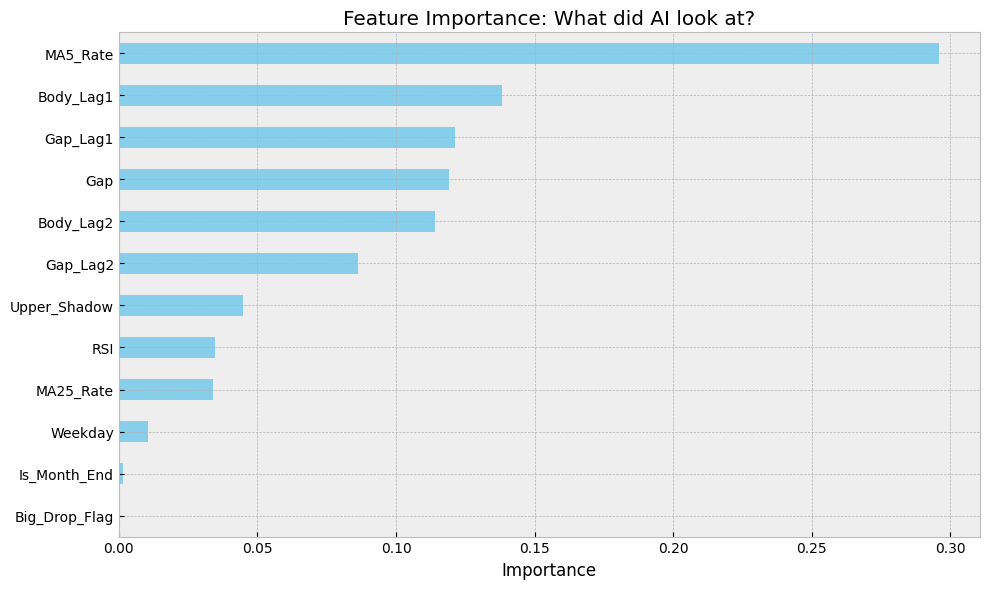

In [12]:
# --------------------------------------------------
# モデルの評価と結果の分析
# --------------------------------------------------

# 閾値ごとのシミュレーション
thresholds = [0.50, 0.51, 0.52, 0.53, 0.54, 0.55]
results = []

for th in thresholds:
    # 確率が閾値以上のときだけ「Buy」
    buy_mask = probs >= th
    
    if buy_mask.sum() > 0:
        # Precision: 買ったうち、本当に上がった割合
        precision = y_test[buy_mask].mean()
        count = buy_mask.sum()
        # 期待収益の概算（手数料なし、値幅ベース）
        # 実際に買った日のNext_Day_Returnを集計
        total_return = test_df.loc[buy_mask, 'Day_Return'].sum()
    else:
        precision = 0
        count = 0
        total_return = 0
        
    results.append({
        '閾値(Score)': f"{th:.2f}",
        'エントリー回数': count,
        '週平均回数': f"{count / (len(test_df)/5):.1f}回",
        '適合率(Precision)': f"{precision:.2%}",
        '合計獲得値幅': f"{total_return:.1f}円"
    })

results_df = pd.DataFrame(results)

print("\n--- シミュレーション結果 ---")
print(f"テスト期間: 2025/01/01 ~ {test_df['日付'].max().strftime('%Y/%m/%d')}")
print(f"何もしない場合(Base Win Rate): {y_test.mean():.2%}")
print("-" * 60)
print(results_df)
print("-" * 60)

# 特徴量重要度の可視化
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='skyblue')
plt.title('Feature Importance: What did AI look at?')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance_gb.png')


### 修正版

In [13]:
# ----------------------------------------------------------
# 特徴エンジニアリング
# ----------------------------------------------------------

# ベースデータをリセット
df_clean = df.copy().sort_values('日付')

# 1. 特徴量の計算（全て「当日」の値として計算し、最後にシフトする）
# RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_clean['RSI'] = calculate_rsi(df_clean['終値'])

# 移動平均乖離率
for span in [5, 25]:
    ma = df_clean['終値'].rolling(window=span).mean()
    df_clean[f'MA{span}_Rate'] = (df_clean['終値'] - ma) / ma

# ローソク足特徴
df_clean['Body'] = (df_clean['終値'] - df_clean['始値']) / df_clean['始値']
df_clean['Upper_Shadow'] = (df_clean['高値'] - df_clean[['始値', '終値']].max(axis=1)) / df_clean['始値']

# カレンダー
df_clean['Weekday'] = df_clean['日付'].dt.weekday
df_clean['Is_Month_End'] = df_clean['日付'].dt.is_month_end.astype(int)

# --- シフト処理 ---
# 予測に使う特徴量（X）は、全て「前日（1日前）」のデータでなければならない
features_to_shift = ['RSI', 'MA5_Rate', 'MA25_Rate', 'Body', 'Upper_Shadow']
for f in features_to_shift:
    df_clean[f'{f}_Lag1'] = df_clean[f].shift(1) # 前日の値
    df_clean[f'{f}_Lag2'] = df_clean[f].shift(2) # 前々日の値

# カレンダー情報は「当日」のものでOK（朝起きれば今日が何曜日はわかるから）
final_features = [
    'RSI_Lag1', 'MA5_Rate_Lag1', 'MA25_Rate_Lag1', 
    'Body_Lag1', 'Body_Lag2', 'Upper_Shadow_Lag1',
    'Weekday', 'Is_Month_End'
]

# ターゲットは「当日」の動き
df_clean['Target'] = ((df_clean['終値'] - df_clean['始値']) > 0).astype(int)
df_clean['Day_Return'] = df_clean['終値'] - df_clean['始値']

# 欠損値削除
df_final = df_clean.dropna().reset_index(drop=True)

# --- 3度目の正直：モデル学習 ---
train_df = df_final[df_final['日付'] < '2024-01-01']
test_df = df_final[df_final['日付'] >= '2024-01-01']

X_train = train_df[final_features]
y_train = train_df['Target']
X_test = test_df[final_features]
y_test = test_df['Target']

model_final = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

model_final.fit(X_train, y_train)
probs_final = model_final.predict_proba(X_test)[:, 1]

# 結果検証
print(f"--- 改善結果（2025年以降）---")
print(f"ベースライン勝率: {y_test.mean():.2%}")

thresholds = [0.50, 0.52, 0.53, 0.54, 0.55]
results_final = []

for th in thresholds:
    buy_mask = probs_final >= th
    if buy_mask.sum() > 0:
        win_rate = y_test[buy_mask].mean()
        count = buy_mask.sum()
        avg_profit = test_df.loc[buy_mask, 'Day_Return'].mean()
    else:
        win_rate = 0
        count = 0
        avg_profit = 0
        
    results_final.append({
        '閾値': f"{th:.2f}",
        '件数': count,
        '勝率(Precision)': f"{win_rate:.2%}",
        '平均利益(円)': f"{avg_profit:.2f}円"
    })

print(pd.DataFrame(results_final))

# 特徴量重要度
importances_final = pd.Series(model_final.feature_importances_, index=final_features).sort_values(ascending=False)
print("\n重要な特徴量:")
print(importances_final)

--- 改善結果（2025年以降）---
ベースライン勝率: 44.76%
     閾値  件数 勝率(Precision) 平均利益(円)
0  0.50  11        36.36%  -0.51円
1  0.52   8        37.50%  -0.49円
2  0.53   4        25.00%  -0.65円
3  0.54   3        33.33%  -0.40円
4  0.55   3        33.33%  -0.40円

重要な特徴量:
MA5_Rate_Lag1        0.223294
MA25_Rate_Lag1       0.204338
Body_Lag1            0.191209
RSI_Lag1             0.133590
Body_Lag2            0.122981
Upper_Shadow_Lag1    0.077289
Weekday              0.027391
Is_Month_End         0.019908
dtype: float64


### 3. 最終モデル（トレンドフォロー戦略）

In [14]:
# --- 全特徴量統合計計算 ---

df_final_v2 = df.copy().sort_values('日付')

# 1. 基本特徴量
# RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_final_v2['RSI'] = calculate_rsi(df_final_v2['終値'])
# Body (日中の勢い)
df_final_v2['Body'] = (df_final_v2['終値'] - df_final_v2['始値']) / df_final_v2['始値']
# MA (移動平均)
df_final_v2['MA25'] = df_final_v2['終値'].rolling(window=25).mean()

# 2. 新・トレンド特徴量
# 25日線の傾き（3日前と比較）
df_final_v2['Trend_Slope'] = df_final_v2['MA25'] - df_final_v2['MA25'].shift(3)
# 直近5日間の勝率（地合いの良さ）
df_final_v2['Target'] = ((df_final_v2['終値'] - df_final_v2['始値']) > 0).astype(int)
df_final_v2['Recent_Win_Rate'] = df_final_v2['Target'].rolling(window=5).mean()

# 3. シフト処理（リーク防止：すべて昨日の値にする）
features_base = ['RSI', 'Body', 'Trend_Slope', 'Recent_Win_Rate']
final_feature_names = []

for f in features_base:
    df_final_v2[f'{f}_Lag1'] = df_final_v2[f].shift(1)
    final_feature_names.append(f'{f}_Lag1')

# 曜日（当日の値でOK）
df_final_v2['Weekday'] = df_final_v2['日付'].dt.weekday
final_feature_names.append('Weekday')

# データセット準備
df_model_final = df_final_v2.dropna().reset_index(drop=True)
# Targetの再確認（Day Return）
df_model_final['Day_Return'] = df_model_final['終値'] - df_model_final['始値']

# 学習・テスト分割
train_f = df_model_final[df_model_final['日付'] < '2024-01-01']
test_f = df_model_final[df_model_final['日付'] >= '2024-01-01']

X_train_f = train_f[final_feature_names]
y_train_f = train_f['Target']
X_test_f = test_f[final_feature_names]
y_test_f = test_f['Target']

# モデル学習
model_f = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=10,
    random_state=42
)

model_f.fit(X_train_f, y_train_f)
probs_f = model_f.predict_proba(X_test_f)[:, 1]

# 結果表示
print("--- 最終モデル（トレンド重視）の評価 ---")
print(f"特徴量: {final_feature_names}")

thresholds = [0.50, 0.51, 0.52, 0.53]
results_list = []

for th in thresholds:
    buy_mask = probs_f >= th
    count = buy_mask.sum()
    if count > 0:
        win_rate = y_test_f[buy_mask].mean()
        profit = test_f.loc[buy_mask, 'Day_Return'].sum()
    else:
        win_rate = 0
        profit = 0
        
    results_list.append({
        '閾値': f"{th:.2f}",
        '件数': count,
        '勝率': f"{win_rate:.2%}",
        '損益合計': f"{profit:.1f}円"
    })

print(pd.DataFrame(results_list))

# 特徴量重要度
imp = pd.Series(model_f.feature_importances_, index=final_feature_names).sort_values(ascending=False)
print("\n重要な特徴量:")
print(imp)



--- 最終モデル（トレンド重視）の評価 ---
特徴量: ['RSI_Lag1', 'Body_Lag1', 'Trend_Slope_Lag1', 'Recent_Win_Rate_Lag1', 'Weekday']
     閾値   件数      勝率   損益合計
0  0.50  146  52.74%  20.9円
1  0.51  141  53.19%  23.2円
2  0.52  125  52.80%  22.0円
3  0.53  121  52.07%  20.1円

重要な特徴量:
RSI_Lag1                0.302962
Body_Lag1               0.291426
Trend_Slope_Lag1        0.268187
Weekday                 0.074134
Recent_Win_Rate_Lag1    0.063291
dtype: float64


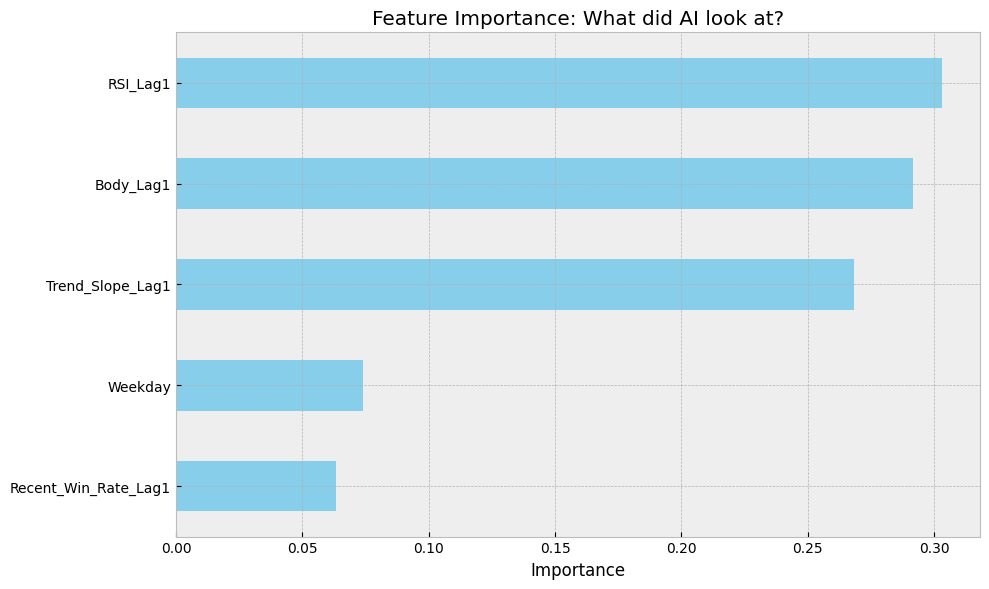

In [19]:
# 特徴量重要度の可視化
importances = pd.Series(model_f.feature_importances_, index=final_feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='skyblue')
plt.title('Feature Importance: What did AI look at?')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance_gb_f.png')